In [3]:
# ==========================================
# 0. 环境设置与配置 (Configuration)
# ==========================================
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, confusion_matrix  # ✅ 添加confusion_matrix
import seaborn as sns
import gc
import os

# ✅ 1. 检查GPU并定义设备（移至顶部）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ 2. 定义全局配置参数（移至顶部）
CONFIG = {
    "model_ckpt": "distilbert-base-uncased",
    "batch_size": 64,
    "learning_rate": 3e-5,
    "num_epochs": 4,         # 与实验中的epochs保持一致
    "weight_decay": 0.01,
    "eval_strategy": "epoch",
    "num_labels": 6          # emotion数据集有6类
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# ✅ 3. 加载数据集和分词器（移至顶部）
print("\n=== 加载数据集和分词器 ===")
dataset = load_dataset("emotion")
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_ckpt"])

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)
print("Dataset and tokenizer loaded successfully.")

# ✅ 4. 定义model_init函数（新增）
def model_init():
    """为Trainer提供初始化模型"""
    return AutoModelForSequenceClassification.from_pretrained(
        CONFIG["model_ckpt"],
        num_labels=CONFIG["num_labels"]
    ).to(device)

# ✅ 5. 定义评估指标函数
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# 6. 定义超参数网格
experiments = [
    {"name": "Baseline",  "lr": 3e-5, "bs": 32, "wd": 0.01},
    {"name": "Low_LR",    "lr": 1e-5, "bs": 32, "wd": 0.01},
    {"name": "High_LR",   "lr": 5e-5, "bs": 32, "wd": 0.01},
    {"name": "Small_BS",  "lr": 3e-5, "bs": 16, "wd": 0.01},
    {"name": "High_WD",   "lr": 3e-5, "bs": 32, "wd": 0.1},
]

# 结果存储
results_df = []

# ✅ 7. 配置matplotlib（移至顶部）
plt.rcParams.update({
    "font.family": "monospace",
    "font.monospace": ["Consolas"],
    "axes.unicode_minus": False
})

# 下载并应用主题样式
if not os.path.exists('rose-pine-dawn.mplstyle'):
    !wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -O rose-pine-dawn.mplstyle
plt.style.use('rose-pine-dawn.mplstyle')

# ==========================================
# 2. 循环执行实验
# ==========================================
print(f"\n=== 开始执行 {len(experiments)} 组对比实验 ===")

for exp in experiments:
    print(f"\n{'='*50}")
    print(f"Running Experiment: {exp['name']} ...")
    print(f"LR: {exp['lr']}, Batch Size: {exp['bs']}, Weight Decay: {exp['wd']}")
    print(f"{'='*50}")

    # 清理显存 (非常重要，防止 OOM)
    torch.cuda.empty_cache()
    gc.collect()

    # 定义训练参数
    args = TrainingArguments(
        output_dir=f"./results_{exp['name']}",
        learning_rate=exp['lr'],
        per_device_train_batch_size=exp['bs'],
        per_device_eval_batch_size=exp['bs'],
        num_train_epochs=4,
        weight_decay=exp['wd'],
        eval_strategy="epoch", # Changed from evaluation_strategy
        save_strategy="epoch",
        logging_steps=50,
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        save_total_limit=1,             # 节省磁盘空间
        dataloader_pin_memory=False     # 避免GPU内存问题
    )

    # ✅ 修复：使用dataset_encoded而非encoded_dataset
    trainer = Trainer(
        model_init=model_init,
        args=args,
        train_dataset=dataset_encoded["train"],
        eval_dataset=dataset_encoded["validation"],
        compute_metrics=compute_metrics,
        processing_class=tokenizer,
    )

    # 开始训练
    train_result = trainer.train()

    # 获取最佳的评估结果
    eval_result = trainer.evaluate()

    # 记录数据
    results_df.append({
        "Experiment": exp['name'],
        "LR": exp['lr'],
        "Batch_Size": exp['bs'],
        "Weight_Decay": exp['wd'],
        "Best_Val_Loss": eval_result['eval_loss'],
        "Best_Accuracy": eval_result['eval_accuracy'],
        "Training_Runtime": train_result.metrics['train_runtime']
    })

    print(f"✅ Experiment {exp['name']} completed - Accuracy: {eval_result['eval_accuracy']:.4f}")

# 3. 展示最终对比表
final_table = pd.DataFrame(results_df)
print("\n" + "="*60)
print("=== 实验结果汇总 ===")
print("="*60)
final_table_sorted = final_table.sort_values(by="Best_Accuracy", ascending=False)
display(final_table_sorted)

# 找出最佳实验
best_exp = final_table_sorted.iloc[0]
print(f"\n🏆 最佳实验配置: {best_exp['Experiment']}")
print(f"   最佳准确率: {best_exp['Best_Accuracy']:.4f}")
print(f"   对应超参数: LR={best_exp['LR']}, BS={best_exp['Batch_Size']}, WD={best_exp['Weight_Decay']}")


Using device: cuda
Configuration:
  model_ckpt: distilbert-base-uncased
  batch_size: 64
  learning_rate: 3e-05
  num_epochs: 4
  weight_decay: 0.01
  eval_strategy: epoch
  num_labels: 6

=== 加载数据集和分词器 ===


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset and tokenizer loaded successfully.

=== 开始执行 5 组对比实验 ===

Running Experiment: Baseline ...
LR: 3e-05, Batch Size: 32, Weight Decay: 0.01


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.207600,0.186644,0.929000
2,0.126100,0.147794,0.934500
3,0.091700,0.138835,0.938500
4,0.060300,0.137867,0.944500


✅ Experiment Baseline completed - Accuracy: 0.9445

Running Experiment: Low_LR ...
LR: 1e-05, Batch Size: 32, Weight Decay: 0.01


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.393700,0.311106,0.911000
2,0.191900,0.184168,0.932000
3,0.155000,0.164264,0.935500
4,0.125500,0.158640,0.935000


✅ Experiment Low_LR completed - Accuracy: 0.9355

Running Experiment: High_LR ...
LR: 5e-05, Batch Size: 32, Weight Decay: 0.01


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.206300,0.202897,0.926500
2,0.123500,0.142164,0.939000
3,0.078100,0.142960,0.941500
4,0.047400,0.159980,0.938000


✅ Experiment High_LR completed - Accuracy: 0.9415

Running Experiment: Small_BS ...
LR: 3e-05, Batch Size: 16, Weight Decay: 0.01


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.219600,0.195165,0.929000
2,0.123200,0.155288,0.935500
3,0.095700,0.158752,0.939500
4,0.050000,0.176577,0.940500


✅ Experiment Small_BS completed - Accuracy: 0.9405

Running Experiment: High_WD ...
LR: 3e-05, Batch Size: 32, Weight Decay: 0.1


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.206400,0.190456,0.927000
2,0.127100,0.146647,0.941500
3,0.092300,0.136634,0.943000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.206400,0.190456,0.927000
2,0.127100,0.146647,0.941500
3,0.092300,0.136634,0.943000
4,0.060100,0.135934,0.943000


✅ Experiment High_WD completed - Accuracy: 0.9430

=== 实验结果汇总 ===


,Experiment,LR,Batch_Size,Weight_Decay,Best_Val_Loss,Best_Accuracy,Training_Runtime
0,Baseline,0.00003,32,0.01,0.137867,0.9445,489.0757
4,High_WD,0.00003,32,0.10,0.136634,0.9430,509.1513
2,High_LR,0.00005,32,0.01,0.142960,0.9415,499.1923
3,Small_BS,0.00003,16,0.01,0.176577,0.9405,546.6383
1,Low_LR,0.00001,32,0.01,0.164264,0.9355,492.5596



🏆 最佳实验配置: Baseline
   最佳准确率: 0.9445
   对应超参数: LR=3e-05, BS=32, WD=0.01


In [5]:
# 在cell-0的实验循环结束后，final_table_sorted定义之后添加：

# 找出最佳实验
best_exp = final_table_sorted.iloc[0]
best_exp_name = best_exp['Experiment']
best_accuracy = best_exp['Best_Accuracy']

print(f"\n🏆 最佳实验配置: {best_exp_name}")
print(f"   最佳准确率: {best_accuracy:.4f}")
print(f"   对应超参数: LR={best_exp['LR']}, BS={best_exp['Batch_Size']}, WD={best_exp['Weight_Decay']}")

# ✅ 保存最佳实验的trainer（修复关键点）
# 需要重新运行最佳实验来获取trainer
print(f"\n=== 重新加载最佳实验: {best_exp_name} ===")

# 重新执行最佳实验
best_config = next(exp for exp in experiments if exp['name'] == best_exp_name)

torch.cuda.empty_cache()
gc.collect()

args = TrainingArguments(
    output_dir=f"./results_{best_config['name']}",
    learning_rate=best_config['lr'],
    per_device_train_batch_size=best_config['bs'],
    per_device_eval_batch_size=best_config['bs'],
    num_train_epochs=4,
    weight_decay=best_config['wd'],
    eval_strategy="epoch", # 修正了参数名
    save_strategy="epoch",
    logging_steps=50,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    dataloader_pin_memory=False
)

best_trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

# 重新训练最佳模型
best_trainer.train()
best_trainer.evaluate()

print(f"✅ 最佳模型trainer已保存，可用于错误分析")


🏆 最佳实验配置: Baseline
   最佳准确率: 0.9445
   对应超参数: LR=3e-05, BS=32, WD=0.01

=== 重新加载最佳实验: Baseline ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# ==========================================
# 数据加载 (Data Loading)
# ==========================================
# 加载情感分类数据集 (通常是 'emotion' 数据集)
dataset = load_dataset("emotion")

# 查看数据结构
print("Dataset Structure:", dataset)
train_ds = dataset["train"]
print(f"Sample data: {train_ds[0]}")

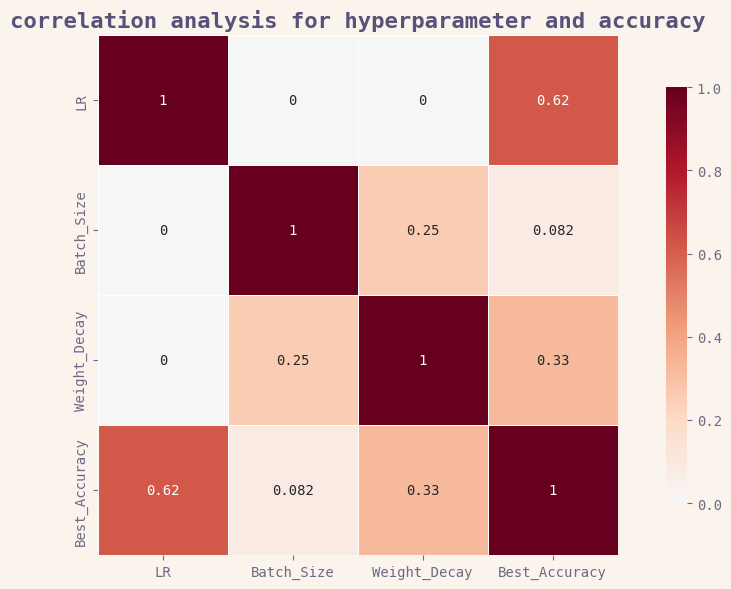

In [7]:
import plotly.express as px
import plotly.graph_objects as go

# 添加更多维度（训练时间）
fig = px.parallel_coordinates(
    final_table,
    dimensions=["LR", "Batch_Size", "Weight_Decay", "Best_Accuracy", "Training_Runtime"],
    color="Best_Accuracy",
    color_continuous_scale=px.colors.diverging.Tealrose,
    title="超参数对模型性能的多维影响分析",
    labels={
        "LR",
        "Batch_Size",
        "Weight_Decay",
        "Best_Accuracy",
        "Training_Runtime"
    }
)
fig.show()

# 计算超参数与准确率的相关性
import seaborn as sns
import matplotlib.pyplot as plt

# 相关性矩阵
corr_data = final_table[["LR", "Batch_Size", "Weight_Decay", "Best_Accuracy"]].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_data, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('correlation analysis for hyperparameter and accuracy', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 散点图展示两两超参数关系
fig = px.scatter_matrix(
    final_table,
    dimensions=["LR", "Batch_Size", "Weight_Decay", "Best_Accuracy"],
    color="Best_Accuracy",
    title="hyperparameter distribution matrix",
    color_continuous_scale=px.colors.diverging.Tealrose
)
fig.show()

# 按准确率排序的条形图
final_sorted = final_table.sort_values('Best_Accuracy', ascending=True)

fig = go.Figure()
fig.add_trace(go.Bar(
    y=final_sorted['Experiment'],
    x=final_sorted['Best_Accuracy'],
    orientation='h',
    marker=dict(
        color=final_sorted['Best_Accuracy'],
        colorscale='Tealrose',
        showscale=True,
        colorbar=dict(title="accuracy")
    ),
    text=[f"{acc:.4f}" for acc in final_sorted['Best_Accuracy']],
    textposition='auto'
))

fig.update_layout(
    title="configuration performance ranking",
    xaxis_title="test accuracy",
    yaxis_title="experiment configuration",
    height=500
)
fig.show()

In [ ]:
# ==========================================
# 错误分析 (Error Analysis)
# ==========================================
from torch.nn.functional import cross_entropy

def analyze_model_errors(trainer, dataset_split="validation"):
    """分析指定训练器的模型错误"""
    # 获取模型
    model = trainer.model
    tokenizer = trainer.tokenizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward_pass_with_label(batch):
        inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
        with torch.no_grad():
            output = model(**inputs)
            pred_label = torch.argmax(output.logits, axis=-1)
            loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
        return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

    # 获取指定数据分割
    dataset = dataset_encoded[dataset_split]
    dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    print(f"\n--- Performing Error Analysis on {dataset_split} set ---")
    dataset_with_loss = dataset.map(forward_pass_with_label, batched=True, batch_size=16)

    # 转为DataFrame
    dataset_with_loss.set_format("pandas")
    cols = ["text", "label", "predicted_label", "loss"]
    df_test = dataset_with_loss[:][cols]
    df_test["label"] = df_test["label"].apply(lambda x: dataset["train"].features["label"].int2str(x))
    df_test["predicted_label"] = df_test["predicted_label"].apply(lambda x: dataset["train"].features["label"].int2str(x))

    return df_test

# 使用最佳实验的训练器进行分析

In [ ]:
from torch.nn.functional import cross_entropy
import seaborn as sns

print("\n=== 最佳模型错误分析可视化 ===")

# Step 1: 获取最佳模型的预测结果和损失
def get_model_predictions_and_loss(trainer, dataset_split="validation"):
    model = trainer.model
    tokenizer = trainer.tokenizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 获取验证集数据
    dataset = dataset_encoded[dataset_split]
    dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    # 计算每个样本的损失和预测
    def forward_pass(batch):
        inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
        with torch.no_grad():
            output = model(**inputs)
            pred_label = torch.argmax(output.logits, axis=-1)
            loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
        return {"loss": loss.cpu().numpy(),
                "predicted_label": pred_label.cpu().numpy(),
                "label": batch["label"].cpu().numpy()}

    print("计算模型预测和损失...")
    dataset_with_pred = dataset.map(forward_pass, batched=True, batch_size=16)

    # 转为DataFrame
    dataset_with_pred.set_format("pandas")
    df = dataset_with_pred[:][["text", "label", "predicted_label", "loss"]]
    df["label"] = df["label"].apply(lambda x: dataset["train"].features["label"].int2str(x))
    df["predicted_label"] = df["predicted_label"].apply(lambda x: dataset["train"].features["label"].int2str(x))

    return df

# 获取最佳模型的错误分析数据
df_test = get_model_predictions_and_loss(best_trainer)

# 获取预测结果用于混淆矩阵
from sklearn.metrics import confusion_matrix
y_true = [dataset["train"].features["label"].int2str(label) for label in dataset_encoded["validation"]["label"]]
y_pred = df_test["predicted_label"].tolist()
label_names = dataset["train"].features["label"].names

# 图1: 混淆矩阵
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred, labels=label_names)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'shrink': 0.8})
plt.title('confusion matrix - best BERT', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('predicted label', fontsize=14)
plt.ylabel('true label', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

# 图2: 各类别错误率条形图
error_by_class = df_test[df_test["label"] != df_test["predicted_label"]].groupby("label").size()
total_by_class = df_test.groupby("label").size()
error_rates = (error_by_class / total_by_class * 100).fillna(0)

plt.figure(figsize=(12, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(error_rates)))
bars = error_rates.plot(kind='bar', color=colors, alpha=0.8, edgecolor='black')
plt.title('error rate analysis for different types', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('emotioin type', fontsize=14)
plt.ylabel('error rate (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)

# 在每个条形上添加数值标签
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# 图3: 损失值分布直方图
plt.figure(figsize=(12, 6))
plt.hist(df_test["loss"], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('loss distribution - identifying anomalies', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('loss', fontsize=14)
plt.ylabel('number of samples', fontsize=14)
plt.axvline(df_test["loss"].mean(), color='red', linestyle='--',
            label=f'均值: {df_test["loss"].mean():.3f}')
plt.axvline(df_test["loss"].mean() + 2*df_test["loss"].std(), color='orange', linestyle='--',
            label=f'均值+2σ: {df_test["loss"].mean() + 2*df_test["loss"].std():.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 打印关键统计信息
print("\n=== 错误分析统计 ===")
total_errors = len(df_test[df_test['label'] != df_test['predicted_label']])
total_samples = len(df_test)
error_rate = total_errors / total_samples * 100

print(f"总样本数: {total_samples}")
print(f"错误分类样本数: {total_errors}")
print(f"整体错误率: {error_rate:.2f}%")
print(f"平均损失值: {df_test['loss'].mean():.4f}")
print(f"损失值标准差: {df_test['loss'].std():.4f}")

# 显示损失最高的5个样本（异常样本）
print("\n🔴 损失最高的5个样本（可能的数据标注错误或极难样本）:")
top_losses = df_test.sort_values("loss", ascending=False).head(5)
for i, (idx, row) in enumerate(top_losses.iterrows(), 1):
    print(f"{i}. 真实标签: {row['label']} | 预测标签: {row['predicted_label']} | 损失: {row['loss']:.4f}")
    print(f"   文本: {row['text'][:100]}...")
    print()